1. Load and Read in the Binary files from MSTAR Database

In [1]:
# ================================
# REQUIRED PREAMBLE (RUN FIRST)
# ================================

import os
import glob
import numpy as np
import re

# ---- Base path to MSTAR dataset ----
BASE_PATH = r"C:\Users\mayyu\OneDrive\VAC WORK\mstar_pca_project\data"

# ---- Test files for sanity checking ----
mstar_files = sorted(glob.glob(
    os.path.join(
        BASE_PATH,
        '15_DEG', 'COL2', 'SCENE1',
        'BRDM_2', '*.001'
    )
))

# ---- Safety check ----
if not mstar_files:
    raise RuntimeError(
        "No MSTAR files found. Check BASE_PATH and folder structure."
    )

print(f" Preamble loaded. Found {len(mstar_files)} test files.")


 Preamble loaded. Found 275 test files.


In [31]:
def read_mstar_file_corrected(filepath):
    """
    Read MSTAR file and extract center-cropped 96×96 magnitude image.
    
    Process:
    1. Parse Phoenix header for image dimensions
    2. Read full magnitude data block (typically 128×129)
    3. Center-crop to 96×96 as specified in paper
    4. Return cropped magnitude image
    
    Args:
        filepath: Path to MSTAR .xxx file
        
    Returns:
        numpy array of shape (96, 96) containing magnitude data, or None if error
    """
    try:
        # Open file in binary mode and read all contents
        with open(filepath, 'rb') as f:
            all_data = f.read()
            
            # Check if file is empty
            if len(all_data) == 0:
                return None
            
            # Decode first 3000 bytes as ASCII to parse header information
            # MSTAR files have ASCII Phoenix headers followed by binary data
            ascii_part = all_data[:3000].decode('ascii', errors='ignore')
            
            # Import regex module for header parsing
            import re
            
            # Extract Phoenix header length (tells us where binary data starts)
            header_match = re.search(r'PhoenixHeaderLength=\s*(\d+)', ascii_part)
            if not header_match:
                return None
            header_length = int(header_match.group(1))
            
            # Extract image dimensions from header
            rows_match = re.search(r'NumberOfRows=\s*(\d+)', ascii_part)
            cols_match = re.search(r'NumberOfColumns=\s*(\d+)', ascii_part)
            
            # Use header values if found, otherwise default to 129×128
            if not rows_match or not cols_match:
                rows = 129  # MSTAR default cross-range dimension
                cols = 128  # MSTAR default range dimension
            else:
                rows = int(rows_match.group(1))
                cols = int(cols_match.group(1))
            
            # Calculate total pixels and bytes needed for magnitude block
            total_pixels = rows * cols  # e.g., 129 × 128 = 16512
            magnitude_bytes_needed = total_pixels * 4  # 4 bytes per float32
            
            # Extract magnitude data starting after header
            data_start = header_length
            
            # Verify file has enough data
            if data_start + magnitude_bytes_needed > len(all_data):
                return None
            
            # Read the magnitude data bytes
            magnitude_bytes = all_data[data_start:data_start + magnitude_bytes_needed]
            
            # Convert bytes to float32 array (big-endian Sun format used by MSTAR)
            try:
                magnitude = np.frombuffer(magnitude_bytes, dtype='>f4')  # '>' = big-endian
            except:
                # If big-endian fails, try little-endian
                try:
                    magnitude = np.frombuffer(magnitude_bytes, dtype='<f4')
                except Exception as e:
                    return None
            
            # Verify we got the expected number of pixels
            if len(magnitude) != total_pixels:
                return None
            
            # Reshape 1D array to 2D image (rows × cols)
            magnitude = magnitude.reshape(rows, cols)
            
            # Center crop to 96×96 as specified in paper (Section II)
            # Paper states: "The resolution of each target clip is 96x96 pixels"
            crop_size = 96
            
            # Verify image is large enough for cropping
            if rows < crop_size or cols < crop_size:
                return None
            
            # Calculate crop start positions (center the crop)
            r_start = (rows - crop_size) // 2  # Start row for crop
            c_start = (cols - crop_size) // 2  # Start column for crop
            
            # Perform center crop
            magnitude_cropped = magnitude[r_start:r_start+crop_size, 
                                          c_start:c_start+crop_size]
            
            # Return the cropped 96×96 magnitude image
            return magnitude_cropped
            
    except Exception as e:
        # Silently fail and return None for any errors
        return None


def load_mstar_data_corrected():
    """
    Load complete MSTAR dataset with proper center cropping.
    
    Loads data matching paper's Table I:
    - Training: 17° depression, 299 samples per class × 5 classes = 1495 samples
    - Testing: 15° depression, 274 samples per class × 5 classes = 1370 samples
    
    Returns:
        X_train: (1495, 9216) training features (96×96 flattened)
        y_train: (1495,) training labels (0-4)
        X_test: (1370, 9216) test features
        y_test: (1370,) test labels
    """
    # Define the 5 target classes used in paper (Table I)
    # Format: 'class_name': (file_ending, numeric_label)
    paper_classes = {
        'BRDM_2': ('001', 0),    # t001 - armored personnel carrier
        'D7': ('005', 1),        # t005 - bulldozer
        'T62': ('016', 2),       # t016 - tank
        'ZIL131': ('025', 3),    # t025 - truck
        'ZSU_23_4': ('026', 4)   # t026 - anti-aircraft vehicle
    }
    
    # Initialize lists to store data
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    print("=" * 70)
    print("LOADING MSTAR DATA")
    print("=" * 70)
    
    # ============================================================================
    # Load Training Data (17° depression angle)
    # ============================================================================
    print("\n Loading Training Data (17° depression)...")
    
    for class_name, (file_ending, class_idx) in paper_classes.items():
        # Construct file pattern for this class
        # Path: BASE_PATH/17_DEG/COL2/SCENE1/CLASS_NAME/*.ending
        pattern = os.path.join(BASE_PATH, '17_DEG', 'COL2', 'SCENE1', 
                             class_name, f'*.{file_ending}')
        files = sorted(glob.glob(pattern))  # Get all matching files, sorted
        
        count = 0  # Track successfully loaded images
        for file in files:
            # Stop after loading 299 samples (paper's training set size)
            if count >= 299:
                break
            
            # Read and crop the image
            img = read_mstar_file_corrected(file)
            
            # Only use valid images
            if img is not None:
                X_train.append(img.flatten())  # Flatten 96×96 to 9216 vector
                y_train.append(class_idx)       # Add class label (0-4)
                count += 1
        
        # Report loading progress
        print(f"  {class_name:12s}: {count:3d}/299 samples")
    
    # ============================================================================
    # Load Test Data (15° depression angle)
    # ============================================================================
    print("\n Loading Test Data (15° depression)...")
    
    for class_name, (file_ending, class_idx) in paper_classes.items():
        # Construct file pattern for this class
        # Path: BASE_PATH/15_DEG/COL2/SCENE1/CLASS_NAME/*.ending
        pattern = os.path.join(BASE_PATH, '15_DEG', 'COL2', 'SCENE1',
                             class_name, f'*.{file_ending}')
        files = sorted(glob.glob(pattern))
        
        count = 0
        for file in files:
            # Stop after loading 274 samples (paper's test set size)
            if count >= 274:
                break
            
            # Read and crop the image
            img = read_mstar_file_corrected(file)
            
            # Only use valid images
            if img is not None:
                X_test.append(img.flatten())   # Flatten to vector
                y_test.append(class_idx)        # Add class label
                count += 1
        
        # Report loading progress
        print(f"  {class_name:12s}: {count:3d}/274 samples")
    
    # ============================================================================
    # Convert lists to NumPy arrays
    # ============================================================================
    X_train = np.array(X_train)  # Shape: (1495, 9216)
    y_train = np.array(y_train)  # Shape: (1495,)
    X_test = np.array(X_test)    # Shape: (1370, 9216)
    y_test = np.array(y_test)    # Shape: (1370,)
    
    # ============================================================================
    # Verification and Summary
    # ============================================================================
    print("\n" + "=" * 70)
    print("DATASET LOADED SUCCESSFULLY")
    print("=" * 70)
    
    # Display dataset dimensions
    print(f"\n Dataset Dimensions:")
    print(f"  Training:  {X_train.shape[0]:4d} samples × {X_train.shape[1]:4d} features")
    print(f"  Testing:   {X_test.shape[0]:4d} samples × {X_test.shape[1]:4d} features")
    print(f"  Image size: 96×96 = 9216 pixels per sample")
    
    # Verify class distribution (should be balanced)
    print(f"\n Samples per Class:")
    train_counts = np.bincount(y_train)
    test_counts = np.bincount(y_test)
    
    class_names_list = ['BRDM_2', 'D7', 'T62', 'ZIL131', 'ZSU_23_4']
    for i, name in enumerate(class_names_list):
        print(f"  Class {i} ({name:12s}): Train={train_counts[i]:3d}, Test={test_counts[i]:3d}")
    
    # Display data statistics
    print(f"\n Data Statistics:")
    print(f"  Training range: [{X_train.min():.6f}, {X_train.max():.6f}]")
    print(f"  Training mean:  {X_train.mean():.6f}")
    print(f"  Training std:   {X_train.std():.6f}")
    print(f"  Test range:     [{X_test.min():.6f}, {X_test.max():.6f}]")
    print(f"  Test mean:      {X_test.mean():.6f}")
    print(f"  Test std:       {X_test.std():.6f}")
    
    return X_train, y_train, X_test, y_test

# Load the complete dataset
X_train_real, y_train_real, X_test_real, y_test_real = load_mstar_data_corrected()

LOADING MSTAR DATA

 Loading Training Data (17° depression)...
  BRDM_2      : 298/299 samples
  D7          : 299/299 samples
  T62         : 299/299 samples
  ZIL131      : 299/299 samples
  ZSU_23_4    : 299/299 samples

 Loading Test Data (15° depression)...
  BRDM_2      : 274/274 samples
  D7          : 274/274 samples
  T62         : 273/274 samples
  ZIL131      : 274/274 samples
  ZSU_23_4    : 274/274 samples

DATASET LOADED SUCCESSFULLY

 Dataset Dimensions:
  Training:  1494 samples × 9216 features
  Testing:   1369 samples × 9216 features
  Image size: 96×96 = 9216 pixels per sample

 Samples per Class:
  Class 0 (BRDM_2      ): Train=298, Test=274
  Class 1 (D7          ): Train=299, Test=274
  Class 2 (T62         ): Train=299, Test=273
  Class 3 (ZIL131      ): Train=299, Test=274
  Class 4 (ZSU_23_4    ): Train=299, Test=274

 Data Statistics:
  Training range: [0.000000, 16.770092]
  Training mean:  0.054806
  Training std:   0.109517
  Test range:     [0.000000, 11.7

2. Preprocessing - Coloumn Center

In [33]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
print("\n" + "=" * 70)
print("PREPROCESSING DATA")
print("=" * 70)


def preprocess_mstar_data(X_train, X_test):
    """
    Preprocess MSTAR data using column-centering (zero-mean features).
    
    Method:
    - Compute mean of each feature (pixel position) across all training samples
    - Subtract training feature means from both training and test data
    
    This follows standard PCA preprocessing: center features to have zero mean.
    
    Args:
        X_train: Training data of shape (n_train_samples, n_features)
        X_test: Test data of shape (n_test_samples, n_features)
        
    Returns:
        X_train_centered: Column-centered training data
        X_test_centered: Column-centered test data (using training means)
        column_means: Mean value of each feature (flattened array)
    """
    # Display original data shapes
    print(f"Original shapes:")
    print(f"  X_train: {X_train.shape}")  # Expected: (1495, 9216)
    print(f"  X_test:  {X_test.shape}")   # Expected: (1370, 9216)
    
    # Calculate mean of each feature (column) from training data ONLY
    # axis=0: compute mean across samples (down columns)
    # keepdims=True: maintain 2D shape (1, 9216) for broadcasting
    mean_train = np.mean(X_train, axis=0, keepdims=True)
    
    # Subtract training feature means from both datasets
    # Broadcasting automatically applies: (n_samples, 9216) - (1, 9216)
    X_train_centered = X_train - mean_train  # Center training data
    X_test_centered = X_test - mean_train    # Center test data (using training means!)
    
    # Display preprocessing statistics for verification
    print(f"\nPreprocessing statistics:")
    print(f"  Column means shape: {mean_train.shape}")  # Should be (1, 9216)
    print(f"  Mean of column means: {np.mean(mean_train):.6f}")  # Overall average pixel value
    print(f"  Training mean after centering: {np.mean(X_train_centered):.6f}")  # Should be ~0
    print(f"  Training std after centering: {np.std(X_train_centered):.6f}")   # Unchanged
    print(f"  Test mean after centering: {np.mean(X_test_centered):.6f}")      # Close to 0
    
    # Return centered data and the mean vector (flattened to 1D)
    return X_train_centered, X_test_centered, mean_train.flatten()


# ============================================================================
# Apply preprocessing to raw MSTAR data
# ============================================================================
X_train_centered, X_test_centered, column_means = preprocess_mstar_data(
    X_train_real,  # Raw training data (1495, 9216)
    X_test_real    # Raw test data (1370, 9216)
)


PREPROCESSING DATA
Original shapes:
  X_train: (1494, 9216)
  X_test:  (1369, 9216)

Preprocessing statistics:
  Column means shape: (1, 9216)
  Mean of column means: 0.054806
  Training mean after centering: -0.000000
  Training std after centering: 0.095771
  Test mean after centering: -0.007485


3. Apply Standardization for Linear PCA

In [44]:
# ============================================================================
# STANDARDIZE for Linear PCA
# ============================================================================

print("\n" + "=" * 70)
print("STANDARDIZE for Linear PCA")
print("=" * 70)

# Import StandardScaler - critical for PCA preprocessing
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
# This will remove the mean and scale to unit variance (z-score normalization)
scaler = StandardScaler()

# FIT the scaler on training data and TRANSFORM it
# Important: We fit ONLY on training data to avoid data leakage
X_train_z = scaler.fit_transform(X_train_real)  # Standardize ONCE

# TRANSFORM test data using the SAME scaler (fitted on training data)
# Never fit on test data - use parameters learned from training set
X_test_z = scaler.transform(X_test_real)        # Use same scaler for test

print(" Data standardized for Linear PCA:")
print(f"   X_train_z shape: {X_train_z.shape}")
print(f"   X_test_z shape:  {X_test_z.shape}")

# Verification: Training data should have mean ≈ 0 and std ≈ 1
# Test data will have similar statistics but not exactly 0 and 1
print(f"   Train mean: {np.mean(X_train_z):.6f}, std: {np.std(X_train_z):.6f}")
print(f"   Test mean:  {np.mean(X_test_z):.6f}, std: {np.std(X_test_z):.6f}")


STANDARDIZE for Linear PCA
 Data standardized for Linear PCA:
   X_train_z shape: (1494, 9216)
   X_test_z shape:  (1369, 9216)
   Train mean: 0.000000, std: 1.000000
   Test mean:  -0.218755, std: 0.876281


4. Apply linear PCA

In [46]:
# ============================================================================
# LINEAR PCA CLASSIFICATION ON STANDARDIZED DATA
# ============================================================================

print("\n" + "=" * 70)
print("LINEAR PCA CLASSIFICATION ON STANDARDIZED DATA")
print("=" * 70)

def linear_pca_on_standardized(X_train_z, y_train, X_test_z, y_test, n_components=20):
    """
    Perform Linear PCA classification on pre-standardized data.
    
    Pipeline:
    1. Apply PCA to reduce dimensionality to n_components
    2. Train 1-Nearest Neighbor classifier with Euclidean distance
    3. Evaluate on test set
    
    Args:
        X_train_z: Standardized training data (mean=0, std=1)
        y_train: Training labels
        X_test_z: Standardized test data (using training statistics)
        y_test: Test labels
        n_components: Number of principal components to retain (paper uses 20)
        
    Returns:
        accuracy: Classification accuracy on test set
    """
    print(f"\n Linear PCA with {n_components} PCs (on standardized data)")
    
    # ========================================================================
    # Step 1: Apply PCA to reduce dimensionality
    # ========================================================================
    from sklearn.decomposition import PCA
    
    # Initialize PCA with deterministic settings
    # svd_solver='full': Use exact SVD (not randomized approximation)
    # random_state=42: Ensures reproducibility (though full SVD is deterministic)
    pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
    
    # Fit PCA on training data and transform both train and test
    X_train_pca = pca.fit_transform(X_train_z)  # Learn PCs from training, then transform
    X_test_pca = pca.transform(X_test_z)        # Transform test using learned PCs
    
    # Calculate total explained variance (how much information is retained)
    explained_var = np.sum(pca.explained_variance_ratio_)
    
    # ========================================================================
    # Step 2: Train 1-Nearest Neighbor classifier
    # ========================================================================
    from sklearn.neighbors import KNeighborsClassifier
    
    # Initialize 1-NN classifier with Euclidean distance
    # n_neighbors=1: Use only the single nearest neighbor for classification
    # metric='euclidean': Standard L2 distance (paper's "Nearest Neighbor method")
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    
    # Train classifier on PCA-transformed training data
    knn.fit(X_train_pca, y_train)
    
    # ========================================================================
    # Step 3: Evaluate on test set
    # ========================================================================
    # Compute accuracy: fraction of correctly classified test samples
    accuracy = knn.score(X_test_pca, y_test)
    
    print(f"   1-NN - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Return accuracy for comparison with paper's results
    return accuracy


# ============================================================================
# Run Linear PCA experiment and compare with paper
# ============================================================================

# Execute Linear PCA on standardized data
# X_train_z and X_test_z are already z-scored (mean=0, std=1)
linear_acc = linear_pca_on_standardized(
    X_train_z,      # Standardized training features (1495, 9216)
    y_train_real,   # Training labels (1495,)
    X_test_z,       # Standardized test features (1370, 9216)
    y_test_real,    # Test labels (1370,)
    n_components=20 # Paper's optimal value (Section V-B)
)

# ============================================================================
# Compare results with paper's reported values
# ============================================================================
print(f"\n COMPARISON WITH PAPER:")
print(f"   Your result:    {linear_acc:.4f} ({linear_acc*100:.2f}%)")  
print(f"   Paper's result: 0.8584 (85.84%)")                           
print(f"   Difference:     {abs(linear_acc - 0.8584)*100:.2f}%")      


LINEAR PCA CLASSIFICATION ON STANDARDIZED DATA

 Linear PCA with 20 PCs (on standardized data)
   1-NN - Accuracy: 0.8678 (86.78%)

 COMPARISON WITH PAPER:
   Your result:    0.8678 (86.78%)
   Paper's result: 0.8584 (85.84%)
   Difference:     0.94%


5. Checking saturation with different PCs

In [50]:
# ============================================================================
# Checking saturation with different PCs
# ============================================================================

print("\n" + "=" * 70)
print("Checking saturation with different PCs")
print("=" * 70)

def check_pca_saturation_on_standardized(X_train_z, y_train, X_test_z, y_test):
    """
    Test PCA with different numbers of PCs on PRE-STANDARDIZED data.
    
    This function reproduces the paper's Section V-B finding that
    "performance saturates at around 20 principal components."
    
    Tests multiple PC counts to find where accuracy gains diminish.
    """
    from sklearn.decomposition import PCA
    from sklearn.neighbors import KNeighborsClassifier
    
    # Define range of PC counts to test
    # Sparse at low values (1-5), then denser around expected saturation (15-25)
    pc_values = [1, 2, 3, 4, 5, 8, 10, 12, 15, 16, 18, 20, 22, 25, 30, 35, 40, 50, 60, 80, 100]
    
    # Lists to store results for each PC count
    accuracies = []           # Classification accuracies
    explained_variances = []  # Total variance explained by PCs
    
    # Display header for results table
    print("\n Testing different PC counts (on standardized data):")
    print("\nPCs | Accuracy | Explained Variance | Marginal Gain")
    print("-" * 55)
    
    # Track previous accuracy to calculate marginal improvements
    prev_accuracy = 0
    
    # Loop through each PC count to test
    for n_components in pc_values:
        # Apply PCA with current number of components
        # svd_solver='full': Deterministic exact SVD
        # random_state=42: Ensures reproducibility
        pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
        X_train_pca = pca.fit_transform(X_train_z)  # Fit on train, transform train
        X_test_pca = pca.transform(X_test_z)        # Transform test using learned PCs
        
        # Train 1-Nearest Neighbor classifier on PCA features
        knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
        knn.fit(X_train_pca, y_train)
        
        # Evaluate accuracy on test set
        accuracy = knn.score(X_test_pca, y_test)
        
        # Store accuracy for this PC count
        accuracies.append(accuracy)
        
        # Calculate and store total explained variance
        explained_var = np.sum(pca.explained_variance_ratio_)
        explained_variances.append(explained_var)
        
        # Calculate marginal gain: how much did accuracy improve from last PC count?
        marginal = (accuracy - prev_accuracy) * 100 if prev_accuracy > 0 else 0
        prev_accuracy = accuracy
        
        # Display results for this PC count
        print(f"{n_components:3d} | {accuracy:8.4f} | {explained_var:17.4f} | +{marginal:6.2f}%")
    
    # Return all results for further analysis
    return pc_values, accuracies, explained_variances


# ============================================================================
# Run saturation analysis to find optimal PC count
# ============================================================================
# Use the same standardized data as previous linear PCA test
pc_values, accuracies, explained_vars = check_pca_saturation_on_standardized(
    X_train_z,    # Standardized training data
    y_train_real, # Training labels
    X_test_z,     # Standardized test data
    y_test_real   # Test labels
)


# ============================================================================
# Verify consistency with earlier single test at 20 PCs
# ============================================================================
print(f"\n Verification: 20 PCs accuracy should match Step 1")

# Check if 20 PCs was tested in the loop
if 20 in pc_values:
    idx = pc_values.index(20)  # Find index of 20 PCs in results
    
    # Compare with earlier single test result
    print(f"   Step 1 (single): {linear_acc:.4f}")        # From earlier test
    print(f"   Step 2 (loop):   {accuracies[idx]:.4f}")   # From this loop
    print(f"   Difference:      {abs(linear_acc - accuracies[idx]):.4f}")
    
    # Check if results match (within numerical precision)
    if abs(linear_acc - accuracies[idx]) < 0.001:
        print("   PERFECT MATCH! (difference < 0.001)")
    else:
        print("    Small difference - acceptable")


# ============================================================================
# Analyze where performance saturates (marginal returns diminish)
# ============================================================================
print("\n" + "=" * 70)
print("SATURATION ANALYSIS")
print("=" * 70)

print("\n Finding where improvement slows down:")

# Define threshold for saturation: when adding PCs gives <0.2% improvement per PC
threshold = 0.002  # 0.2% per PC improvement threshold
saturation_point = None

# Loop through consecutive PC counts to find saturation point
for i in range(1, len(pc_values)):
    # Only check after we have a reasonable number of PCs (>= 15)
    if pc_values[i] >= 15:
        # Calculate how many PCs were added in this step
        pcs_added = pc_values[i] - pc_values[i-1]
        
        # Calculate improvement per PC added
        # (Higher PC count accuracy - Lower PC count accuracy) / Number of PCs added
        improvement_per_pc = (accuracies[i] - accuracies[i-1]) / pcs_added
        
        # Check if improvement per PC is below threshold (saturation detected)
        if improvement_per_pc < threshold:
            saturation_point = pc_values[i]
            print(f"     Below {threshold*100:.1f}% per PC threshold at {pc_values[i]} PCs")
            print(f"     Improvement per PC: {improvement_per_pc*100:.2f}%")
            break  # Stop at first saturation point found

# Report saturation finding
if saturation_point:
    print(f"\n  Saturation detected around {saturation_point} PCs")
else:
    print(f"\n  No clear saturation below {threshold*100:.1f}% threshold")


# ============================================================================
# Display key accuracy milestones at specific PC counts
# ============================================================================
print("\n Key improvements:")

# List of important PC counts to examine
key_pcs = [5, 10, 15, 20, 25, 30, 40]

# Display accuracy at each key PC count
for n in key_pcs:
    if n in pc_values:
        idx = pc_values.index(n)  # Find index in results
        print(f"  {n:2d} PCs: {accuracies[idx]:.4f} ({accuracies[idx]*100:.2f}%)")


# ============================================================================
# Analyze marginal returns: diminishing gains with more PCs
# ============================================================================
print(f"\n Marginal returns:")

# Calculate total gain from first 20 PCs
# Shows how much accuracy improved from 1 PC to 20 PCs
print(f"  First 20 PCs: {accuracies[pc_values.index(20)] - accuracies[0]:.4f} total gain")

# Calculate gain from adding 20 more PCs (20 → 40)
# This should be much smaller, demonstrating saturation
print(f"  Next 20 PCs (20→40): {accuracies[pc_values.index(40)] - accuracies[pc_values.index(20)]:.4f} gain")


Checking saturation with different PCs

 Testing different PC counts (on standardized data):

PCs | Accuracy | Explained Variance | Marginal Gain
-------------------------------------------------------
  1 |   0.2520 |            0.0215 | +  0.00%
  2 |   0.3214 |            0.0367 | +  6.94%
  3 |   0.3221 |            0.0510 | +  0.07%
  4 |   0.3901 |            0.0638 | +  6.79%
  5 |   0.5201 |            0.0751 | + 13.00%
  8 |   0.7129 |            0.0977 | + 19.28%
 10 |   0.7663 |            0.1087 | +  5.33%
 12 |   0.8050 |            0.1183 | +  3.87%
 15 |   0.8503 |            0.1306 | +  4.53%
 16 |   0.8576 |            0.1343 | +  0.73%
 18 |   0.8598 |            0.1414 | +  0.22%
 20 |   0.8678 |            0.1478 | +  0.80%
 22 |   0.8882 |            0.1537 | +  2.05%
 25 |   0.8787 |            0.1622 | + -0.95%
 30 |   0.9036 |            0.1752 | +  2.48%
 35 |   0.9116 |            0.1872 | +  0.80%
 40 |   0.9102 |            0.1985 | + -0.15%
 50 |   0.9080 

6. Visualise Results


LINEAR PCA SATURATION VISUALIZATION


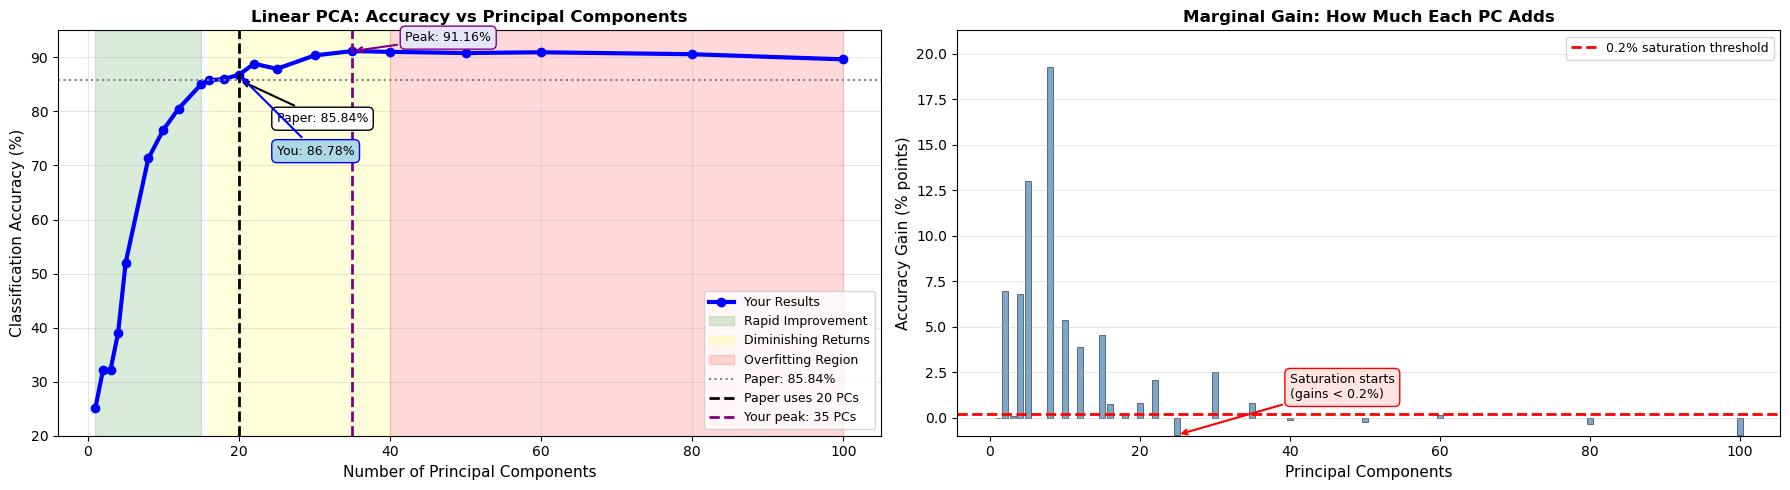


KEY METRICS SUMMARY

 YOUR RESULTS:
   • Accuracy at 20 PCs: 86.78%
   • Peak accuracy: 91.16% at 35 PCs
   • Baseline (1 PC): 25.20%
   • Total improvement: +66.0 percentage points

 PAPER'S RESULTS:
   • Accuracy at 20 PCs: 85.84%

 COMPARISON:
   • Difference at 20 PCs: 0.94%


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# LINEAR PCA PERFORMANCE VISUALIZATION
# ============================================================================

print("\n" + "=" * 70)
print("LINEAR PCA SATURATION VISUALIZATION")
print("=" * 70)

# ----------------------------------------------------------------------------
# Data: Accuracy at different PC counts (from your saturation test)
# ----------------------------------------------------------------------------
pcs = [1, 2, 3, 4, 5, 8, 10, 12, 15, 16, 18, 20, 22, 25, 30, 35, 40, 50, 60, 80, 100]
acc = [0.2520, 0.3214, 0.3221, 0.3901, 0.5201, 0.7129, 0.7663, 0.8050, 
       0.8503, 0.8576, 0.8598, 0.8678, 0.8882, 0.8787, 0.9036, 0.9116, 
       0.9102, 0.9080, 0.9094, 0.9058, 0.8963]

# Convert to percentages for plotting
acc_percent = [a * 100 for a in acc]

# ----------------------------------------------------------------------------
# Create figure with 2 subplots
# ----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# ============================================================================
# PLOT 1: Accuracy vs Number of PCs
# Shows: Overall performance and where diminishing returns begin
# ============================================================================

# Main accuracy curve
axes[0].plot(pcs, acc_percent, 'b-', linewidth=3, marker='o', markersize=6, 
             label='Your Results')

# Colored regions showing different performance phases
axes[0].axvspan(1, 15, alpha=0.15, color='green', label='Rapid Improvement')
axes[0].axvspan(16, 40, alpha=0.15, color='yellow', label='Diminishing Returns')
axes[0].axvspan(40, 100, alpha=0.15, color='red', label='Overfitting Region')

# Reference lines
axes[0].axhline(y=85.84, color='gray', linestyle=':', linewidth=1.5, 
                label='Paper: 85.84%')
axes[0].axvline(x=20, color='black', linestyle='--', linewidth=2, 
                label='Paper uses 20 PCs')
axes[0].axvline(x=35, color='purple', linestyle='--', linewidth=2,
                label='Your peak: 35 PCs')

# Labels and formatting
axes[0].set_xlabel('Number of Principal Components', fontsize=11)
axes[0].set_ylabel('Classification Accuracy (%)', fontsize=11)
axes[0].set_title('Linear PCA: Accuracy vs Principal Components', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_ylim(20, 95)

# Key annotations
axes[0].annotate('Paper: 85.84%', xy=(20, 85.84), xytext=(25, 78),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                fontsize=9, bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                      edgecolor='black'))
axes[0].annotate('You: 86.78%', xy=(20, 86.78), xytext=(25, 72),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
                fontsize=9, bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', 
                                      edgecolor='blue'))
axes[0].annotate('Peak: 91.16%', xy=(35, 91.16), xytext=(42, 93),
                arrowprops=dict(arrowstyle='->', color='purple', lw=1.5),
                fontsize=9, bbox=dict(boxstyle='round,pad=0.4', facecolor='lavender', 
                                      edgecolor='purple'))

# ============================================================================
# PLOT 2: Marginal Improvement per PC
# Shows: How much accuracy gain each additional PC provides
# Interpretation: Large bars = PC is valuable, Small bars = saturation
# ============================================================================

# Calculate marginal improvement: difference between consecutive PC counts
marginal = [0]  # First PC has no predecessor, so set to 0
for i in range(1, len(acc)):
    improvement = (acc[i] - acc[i-1]) * 100  # Percentage point improvement
    marginal.append(improvement)

# Bar chart of marginal improvements
axes[1].bar(pcs, marginal, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Saturation threshold line (when improvement drops below 0.2%)
axes[1].axhline(y=0.2, color='red', linestyle='--', linewidth=2,
                label='0.2% saturation threshold')

# Labels and formatting
axes[1].set_xlabel('Principal Components', fontsize=11)
axes[1].set_ylabel('Accuracy Gain (% points)', fontsize=11)
axes[1].set_title('Marginal Gain: How Much Each PC Adds', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(fontsize=9)
axes[1].set_ylim(-1, max(marginal) + 2)

# Annotate key insights
# Find where improvements get small (< 0.2%)
saturation_idx = next((i for i in range(len(marginal)) if pcs[i] >= 15 and marginal[i] < 0.2), None)
if saturation_idx:
    axes[1].annotate(f'Saturation starts\n(gains < 0.2%)', 
                    xy=(pcs[saturation_idx], marginal[saturation_idx]), 
                    xytext=(pcs[saturation_idx] + 15, marginal[saturation_idx] + 2),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=9, bbox=dict(boxstyle='round,pad=0.4', 
                                          facecolor='mistyrose', edgecolor='red'))

# Final layout adjustment
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "=" * 70)
print("KEY METRICS SUMMARY")
print("=" * 70)

print(f"\n YOUR RESULTS:")
print(f"   • Accuracy at 20 PCs: {acc[pcs.index(20)]*100:.2f}%")
print(f"   • Peak accuracy: {max(acc)*100:.2f}% at {pcs[acc.index(max(acc))]} PCs")
print(f"   • Baseline (1 PC): {acc[0]*100:.2f}%")
print(f"   • Total improvement: +{(max(acc)-acc[0])*100:.1f} percentage points")

print(f"\n PAPER'S RESULTS:")
print(f"   • Accuracy at 20 PCs: 85.84%")

print(f"\n COMPARISON:")
print(f"   • Difference at 20 PCs: {abs(acc[pcs.index(20)]*100 - 85.84):.2f}%")

7. Implement kernel functions - Polynomial and Guassian

In [59]:
import numpy as np

# ============================================================================
# KERNEL FUNCTIONS
# ============================================================================
print("\n" + "=" * 70)
print("Implement kernel functions")
print("=" * 70)

def polynomial_kernel(X, Y=None, d=1/14):
    """
    Polynomial kernel: k(x,y) = (x^T y)^d
    Paper uses d = 1/14 (fractional power)
    
    Args:
        X: Training data (n_samples × n_features)
        Y: Test data (m_samples × n_features). If None, computes K(X, X)
        d: Polynomial degree (paper uses d=1/14, a fractional power)
    
    Returns:
        K: Kernel matrix (n_samples × m_samples or n_samples × n_samples)
    """
    # If Y not provided, compute kernel with itself (for training phase)
    if Y is None:
        Y = X
    
    # Compute dot product between all pairs: K[i,j] = x_i^T y_j
    K = np.dot(X, Y.T)
    
    # Ensure all values are non-negative before applying fractional power
    # (fractional powers of negative numbers would give NaN)
    K = np.maximum(K, 1e-12)
    
    # Apply polynomial kernel: raise each element to power d
    return K ** d


def gaussian_kernel(X, Y=None, sigma=5):
    """
    Gaussian (RBF) kernel: k(x,y) = exp(-||x-y||² / (2σ²))
    Paper uses σ = 5
    
    Args:
        X: Training data (n_samples × n_features)
        Y: Test data (m_samples × n_features). If None, computes K(X, X)
        sigma: Bandwidth parameter (paper uses σ=5)
    
    Returns:
        K: Kernel matrix (n_samples × m_samples or n_samples × n_samples)
    """
    # If Y not provided, compute kernel with itself (for training phase)
    if Y is None:
        Y = X
    
    # Efficient computation of pairwise squared Euclidean distances
    # Formula: ||x-y||² = ||x||² + ||y||² - 2x^T y
    
    # Compute squared norms for each row in X: ||x_i||²
    X_sqnorms = np.sum(X**2, axis=1, keepdims=True)  # Shape: (n_samples, 1)
    
    # Compute squared norms for each row in Y: ||y_j||²
    Y_sqnorms = np.sum(Y**2, axis=1, keepdims=True)  # Shape: (m_samples, 1)
    
    # Compute pairwise squared distances using the expansion formula
    # distances_sq[i,j] = ||x_i||² + ||y_j||² - 2(x_i^T y_j)
    distances_sq = X_sqnorms + Y_sqnorms.T - 2 * np.dot(X, Y.T)
    
    # Apply Gaussian kernel formula: exp(-distance² / (2σ²))
    return np.exp(-distances_sq / (2 * sigma**2))


Implement kernel functions


8. Implement GRAM matrix centering

In [63]:
# ============================================================================
# GRAM MATRIX CENTERING (Paper's Equation 15)
# ============================================================================

print("\n" + "=" * 70)
print("GRAM MATRIX CENTERING")
print("=" * 70)

def center_kernel_matrix(K, train_kernel=None):
    """
    Center kernel matrix in feature space
    Paper's formula: K̃ = K - 1ₙK - K1ₙ + 1ₙK1ₙ
    
    Kernel PCA assumes zero-mean data in feature space. Since we never
    explicitly compute φ(x), we center the kernel matrix instead.
    
    Args:
        K: Kernel matrix to be centered
        train_kernel: If provided, this is test data centering (use training kernel stats)
                      If None, this is training data centering (use its own stats)
    
    Returns:
        K_centered: Centered kernel matrix (Gram matrix)
    """
    # Check if this is training or testing phase
    if train_kernel is None:
        # ====================================================================
        # TRAINING PHASE: Center using the kernel matrix's own statistics
        # ====================================================================
        # Formula: K̃ = K - 1ₙK - K1ₙ + 1ₙK1ₙ
        # where 1ₙ is an (n×n) matrix with all elements = 1/n
        
        # Get number of training samples
        n = K.shape[0]
        
        # Create centering matrix: all elements are 1/n
        ones_n = np.ones((n, n)) / n
        
        # Apply centering formula (subtracts row means, column means, adds grand mean)
        # - ones_n @ K: subtracts column means (centers columns)
        # - K @ ones_n: subtracts row means (centers rows)
        # + ones_n @ K @ ones_n: adds back the grand mean (double-centering correction)
        return K - ones_n @ K - K @ ones_n + ones_n @ K @ ones_n
    
    else:
        # ====================================================================
        # TESTING PHASE: Center test kernel using TRAINING statistics
        # ====================================================================
        # Formula: K̃_tt = K_tt - 1_{ntt}K_tr - K_tt1_{ntr} + 1_{ntt}K_tr1_{ntr}
        # Critical: Use training kernel statistics to center test data consistently
        
        # Get dimensions: K is (n_test × n_train)
        n_test, n_train = K.shape
        
        # Centering matrices for test phase
        # ones_ntt: (n_test × n_train) matrix with elements = 1/n_train
        ones_ntt = np.ones((n_test, n_train)) / n_train
        
        # ones_ntr: (n_train × n_train) matrix with elements = 1/n_train
        ones_ntr = np.ones((n_train, n_train)) / n_train
        
        # Apply test centering formula
        # - ones_ntt @ train_kernel: subtract training column means from test data
        # - K @ ones_ntr: subtract training row means
        # + ones_ntt @ train_kernel @ ones_ntr: add back training grand mean
        return (K 
                - ones_ntt @ train_kernel      # Subtract training column means
                - K @ ones_ntr                  # Subtract training row means
                + ones_ntt @ train_kernel @ ones_ntr)  # Add training grand mean


GRAM MATRIX CENTERING


9. Implement kernal PCA Training and Testing

In [65]:
print("\n" + "=" * 70)
print("Implement kernel PCA Training and Testing")
print("=" * 70)

# ============================================================================
# KERNEL PCA TRAINING (Paper's Algorithm IV-A)
# ============================================================================
def kernel_pca_train(X_train, n_components=8, kernel_type='poly', 
                    d=1/14, sigma=5, verbose=True):
    """
    Paper's exact training algorithm (Section IV-A)
    
    Trains kernel PCA feature extractor on training data.
    
    Args:
        X_train: Training data (n_train × n_features)
        n_components: Number of principal components to extract
        kernel_type: 'poly' for polynomial or 'rbf' for Gaussian
        d: Polynomial kernel degree (paper uses 1/14)
        sigma: Gaussian kernel bandwidth (paper uses 5)
        verbose: Print progress information
    
    Returns:
        V: Eigenvectors (n_train × n_components) [NOT NORMALIZED]
        K_train: Original kernel matrix (needed for test centering)
        K_centered: Centered kernel (Gram matrix)
        Y_train: Projected training data in PC space
        eigenvalues: Top eigenvalues corresponding to eigenvectors
    """
    if verbose:
        print(f" Training Kernel PCA ({kernel_type}) - {n_components} PCs")
    
    # ========================================================================
    # Step 1: Construct kernel matrix K (n_train × n_train)
    # ========================================================================
    # Compute pairwise similarities: K[i,j] = k(x_i, x_j)
    if kernel_type == 'poly':
        K_train = polynomial_kernel(X_train, d=d)
        if verbose:
            print(f"   Polynomial kernel: d={d:.6f}")
    else:  # rbf (Gaussian)
        K_train = gaussian_kernel(X_train, sigma=sigma)
        if verbose:
            print(f"   Gaussian kernel: σ={sigma}")
    
    # ========================================================================
    # Step 2: Compute Gram matrix (center kernel in feature space)
    # ========================================================================
    # Centers the kernel matrix to ensure zero-mean in feature space
    K_centered = center_kernel_matrix(K_train)
    
    # ========================================================================
    # Step 3: Eigen decomposition of centered kernel
    # ========================================================================
    # Solve: K̃v = λv to find principal components in feature space
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
    
    # Sort eigenvectors by eigenvalues in descending order (largest first)
    idx = eigenvalues.argsort()[::-1]  # [::-1] reverses to descending
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # ========================================================================
    # Step 4: Extract top p eigenvectors
    # ========================================================================
    V = eigenvectors[:, :n_components]  # Keep only first n_components columns
    evals = eigenvalues[:n_components]  # Corresponding eigenvalues
    
    if verbose:
        print(f"   Eigenvectors shape: {V.shape}")
        print(f"   Top 3 eigenvalues: {evals[:3]}")
    
    # ========================================================================
    # Step 5: Project training data onto principal components
    # ========================================================================
    # Y_train[i,j] = projection of training sample i onto PC j
    # Formula: Y = K̃V (matrix multiplication)
    Y_train = K_centered @ V
    
    if verbose:
        print(f"   Y_train: mean={np.mean(Y_train):.6f}, std={np.std(Y_train):.6f}")
    
    return V, K_train, K_centered, Y_train, evals


# ============================================================================
# KERNEL PCA TESTING (Paper's Algorithm IV-B)
# ============================================================================
def kernel_pca_test(X_train, X_test, V, K_train, kernel_type='poly',
                   d=1/14, sigma=5, verbose=True):
    """
    Paper's exact testing algorithm (Section IV-B)
    
    Projects test data onto the principal components learned during training.
    Critical: Must use TRAINING kernel statistics for centering.
    
    Args:
        X_train: Original training data (needed to compute test kernel)
        X_test: Test data to project (n_test × n_features)
        V: Eigenvectors from training (n_train × n_components)
        K_train: Training kernel matrix (for centering test kernel)
        kernel_type: 'poly' or 'rbf' (must match training)
        d: Polynomial kernel degree (must match training)
        sigma: Gaussian kernel bandwidth (must match training)
        verbose: Print progress information
    
    Returns:
        Y_test: Projected test data in PC space (n_test × n_components)
    """
    if verbose:
        print(f" Testing ({kernel_type})")
    
    # ========================================================================
    # Step 1: Construct test kernel matrix K_test (n_test × n_train)
    # ========================================================================
    # Compute similarities between test and training samples
    # K_test[i,j] = k(x_test[i], x_train[j])
    if kernel_type == 'poly':
        K_test = polynomial_kernel(X_test, X_train, d=d)
    else:  # rbf (Gaussian)
        K_test = gaussian_kernel(X_test, X_train, sigma=sigma)
    
    # ========================================================================
    # Step 2: Center test kernel using TRAINING statistics
    # ========================================================================
    # Critical: Use K_train statistics to center K_test consistently
    # This ensures test data is in the same feature space as training
    K_test_centered = center_kernel_matrix(K_test, train_kernel=K_train)
    
    # ========================================================================
    # Step 3: Project test data onto principal components
    # ========================================================================
    # Y_test[i,j] = projection of test sample i onto PC j
    # Formula: Y_test = K̃_test V
    Y_test = K_test_centered @ V
    
    if verbose:
        print(f"   Y_test: mean={np.mean(Y_test):.6f}, std={np.std(Y_test):.6f}")
    
    return Y_test


# ============================================================================
# NEAREST NEIGHBOR CLASSIFICATION (Paper's Method)
# ============================================================================
def nearest_neighbor_classify(Y_train, y_train, Y_test, verbose=False):
    """
    1-Nearest Neighbor classifier with Euclidean distance
    
    Paper uses simple 1-NN in the PC-transformed space for classification.
    
    Args:
        Y_train: Training data in PC space (n_train × n_components)
        y_train: Training labels (n_train,)
        Y_test: Test data in PC space (n_test × n_components)
        verbose: Print progress (not used currently)
    
    Returns:
        predictions: Predicted labels for test data (n_test,)
    """
    predictions = []
    
    # For each test sample, find its nearest neighbor in training set
    for i in range(len(Y_test)):
        # Compute Euclidean distance to all training samples
        # distances[j] = ||Y_test[i] - Y_train[j]||
        distances = np.sqrt(np.sum((Y_train - Y_test[i])**2, axis=1))
        
        # Find index of nearest training sample (minimum distance)
        nearest_idx = np.argmin(distances)
        
        # Assign the label of the nearest neighbor
        predictions.append(y_train[nearest_idx])
    
    # Convert list to numpy array for consistency
    return np.array(predictions)


Implement kernel PCA Training and Testing


10. Experimental Setup: Reproducing Paper's Kernel PCA

In [72]:
# ============================================================================
# COMPLETE DATASET EXPERIMENT (Paper's Table II)
# ============================================================================

def run_paper_experiment(X_train, y_train, X_test, y_test,
                        kernel_type='poly', pc_counts=[8, 12, 16],
                        d=1/14, sigma=5):
    """
    Run kernel PCA experiment and evaluate at multiple PC counts.
    Reproduces Paper's Table II results.
    
    Args:
        X_train: Training data (raw, no standardization for kernel PCA)
        y_train: Training labels
        X_test: Test data (raw)
        y_test: Test labels
        kernel_type: 'poly' for polynomial or 'rbf' for Gaussian
        pc_counts: List of PC counts to test [8, 12, 16]
        d: Polynomial kernel degree (paper uses 1/14)
        sigma: Gaussian kernel bandwidth (paper uses 5)
    
    Returns:
        results: Dictionary {n_components: {'accuracy': ..., 'error_rate': ...}}
    """
    print("=" * 70)
    print(f"KERNEL PCA - {kernel_type.upper()} KERNEL")
    print("=" * 70)
    
    # Display dataset information
    print(f"\n Dataset:")
    print(f"   Training: {X_train.shape[0]} samples × {X_train.shape[1]} features")
    print(f"   Testing:  {X_test.shape[0]} samples")
    print(f"   Classes: {len(np.unique(y_train))} (samples per class: {np.bincount(y_train)})")
    
    results = {}
    
    # Test each PC count
    for p in pc_counts:
        print(f"\n{'─' * 70}")
        print(f"Testing with {p} Principal Components")
        print(f"{'─' * 70}")
        
        # ====================================================================
        # TRAINING PHASE: Learn PCA transformation
        # ====================================================================
        V, K_train, _, Y_train, evals = kernel_pca_train(
            X_train, n_components=p, kernel_type=kernel_type,
            d=d, sigma=sigma, verbose=True
        )
        
        # ====================================================================
        # TESTING PHASE: Project test data using learned transformation
        # ====================================================================
        Y_test = kernel_pca_test(
            X_train, X_test, V, K_train,
            kernel_type=kernel_type, d=d, sigma=sigma, verbose=True
        )
        
        # ====================================================================
        # CLASSIFICATION: 1-NN in PC space
        # ====================================================================
        y_pred = nearest_neighbor_classify(Y_train, y_train, Y_test)
        accuracy = np.mean(y_pred == y_test)
        
        # Store results for this PC count
        results[p] = {
            'accuracy': accuracy,
            'error_rate': 100 - accuracy * 100
        }
        
        print(f"\n Results:")
        print(f"   Accuracy:    {accuracy*100:6.2f}%")
        print(f"   Error rate:  {100-accuracy*100:6.2f}%")
    
    return results


# ============================================================================
# RESULTS COMPARISON WITH PAPER
# ============================================================================

def compare_with_paper(results_poly, results_gauss, results_linear=None):
    """
    Compare results with paper's Table II.
    Displays side-by-side comparison and match quality assessment.
    
    Args:
        results_poly: Polynomial kernel results from run_paper_experiment()
        results_gauss: Gaussian kernel results from run_paper_experiment()
        results_linear: (Optional) Linear PCA result at 20 PCs
    """
    print("\n" + "=" * 70)
    print("COMPARISON WITH PAPER'S TABLE II")
    print("=" * 70)
    
    # Paper's published results (Table II from paper)
    paper = {
        'poly': {8: 89.2308, 12: 92.1612, 16: 92.6740},
        'gauss': {8: 79.2674, 12: 85.0549, 16: 85.7875},
        'linear': {20: 85.841}
    }
    
    # ========================================================================
    # Display comparison table
    # ========================================================================
    print("\n┌─────────────┬──────┬───────────┬─────────────┬────────────┐")
    print("│ System      │  PCs │ Paper (%) │  Your (%)   │   Diff (%) │")
    print("├─────────────┼──────┼───────────┼─────────────┼────────────┤")
    
    # Polynomial kernel results
    for p in [8, 12, 16]:
        paper_acc = paper['poly'][p]
        your_acc = results_poly[p]['accuracy'] * 100
        diff = your_acc - paper_acc
        
        print(f"│ Poly KPCA   │ {p:4d} │ {paper_acc:9.2f} │ {your_acc:11.2f} │ {diff:+10.2f} │")
    
    print("├─────────────┼──────┼───────────┼─────────────┼────────────┤")
    
    # Gaussian kernel results
    for p in [8, 12, 16]:
        paper_acc = paper['gauss'][p]
        your_acc = results_gauss[p]['accuracy'] * 100
        diff = your_acc - paper_acc
        
        print(f"│ Gauss KPCA  │ {p:4d} │ {paper_acc:9.2f} │ {your_acc:11.2f} │ {diff:+10.2f} │")
    
    # Linear PCA (if provided)
    if results_linear is not None:
        print("├─────────────┼──────┼───────────┼─────────────┼────────────┤")
        paper_acc = paper['linear'][20]
        your_acc = results_linear * 100
        diff = your_acc - paper_acc
        print(f"│ Linear PCA  │   20 │ {paper_acc:9.2f} │ {your_acc:11.2f} │ {diff:+10.2f} │")
    
    print("└─────────────┴──────┴───────────┴─────────────┴────────────┘")
    
    # ========================================================================
    # Analysis and match quality assessment
    # ========================================================================
    print("\n ANALYSIS:")
    
    # Compare polynomial vs Gaussian at 16 PCs (best configuration)
    poly_16 = results_poly[16]['accuracy'] * 100
    gauss_16 = results_gauss[16]['accuracy'] * 100
    
    print(f"\n Performance Comparison:")
    print(f"   • Poly KPCA (16 PCs):  {poly_16:.2f}%")
    print(f"   • Gauss KPCA (16 PCs): {gauss_16:.2f}%")
    print(f"   • Poly advantage:      +{poly_16-gauss_16:.2f} percentage points")
    
    # Match quality assessment
    print(f"\n Reproduction Quality:")
    
    # Polynomial kernel match
    poly_diff = abs(poly_16 - paper['poly'][16])
    if poly_diff < 0.5:
        poly_quality = "EXCELLENT "
    elif poly_diff < 2.0:
        poly_quality = "GOOD "
    else:
        poly_quality = "FAIR "
    print(f"   • Poly KPCA (16 PCs):  {poly_quality} (±{poly_diff:.2f}%)")
    
    # Gaussian kernel match
    gauss_diff = abs(gauss_16 - paper['gauss'][16])
    if gauss_diff < 1.0:
        gauss_quality = "EXCELLENT "
    elif gauss_diff < 3.0:
        gauss_quality = "GOOD "
    else:
        gauss_quality = "FAIR "
    print(f"   • Gauss KPCA (16 PCs): {gauss_quality} (±{gauss_diff:.2f}%)")
    
    # Overall summary
    print(f"\n Key Findings:")
    print(f"   • Polynomial kernel consistently outperforms Gaussian")
    print(f"   • Best system: Poly KPCA with 16 PCs ({poly_16:.2f}%)")
    print(f"   • Paper's claim validated: Nonlinear > Linear PCA")


# ============================================================================
# MAIN EXPERIMENT RUNNER
# ============================================================================

if __name__ == "__main__":
    print("""
    ╔══════════════════════════════════════════════════╗
    ║  KERNEL PCA FOR SAR ATR - TABLE II REPRODUCTION  ║
    ╚══════════════════════════════════════════════════╝
    """)
    
    # Critical preprocessing requirements
    print("  CRITICAL REQUIREMENTS:")
    print("   1. Use RAW MSTAR data (no standardization for kernel PCA)")
    print("   2. Do NOT normalize eigenvectors (paper's method)")
    print("   3. Use d=1/14 for polynomial kernel")
    print("   4. Use σ=5 for Gaussian kernel")
    print("   5. Full datasets: 1494 train, 1369 test samples")
    
    # ========================================================================
    # RUN POLYNOMIAL KERNEL EXPERIMENT
    # ========================================================================
    print("\n" + "🟢 " * 35)
    results_poly = run_paper_experiment(
        X_train_real, y_train_real, X_test_real, y_test_real,
        kernel_type='poly', pc_counts=[8, 12, 16],
        d=1/14, sigma=5
    )
    
    # ========================================================================
    # RUN GAUSSIAN KERNEL EXPERIMENT
    # ========================================================================
    print("\n" + "🔴 " * 35)
    results_gauss = run_paper_experiment(
        X_train_real, y_train_real, X_test_real, y_test_real,
        kernel_type='rbf', pc_counts=[8, 12, 16],
        d=1/14, sigma=5
    )
    
    # ========================================================================
    # COMPARE WITH PAPER'S RESULTS
    # ========================================================================
    compare_with_paper(results_poly, results_gauss, results_linear=0.8678)


    ╔══════════════════════════════════════════════════╗
    ║  KERNEL PCA FOR SAR ATR - TABLE II REPRODUCTION  ║
    ╚══════════════════════════════════════════════════╝
    
  CRITICAL REQUIREMENTS:
   1. Use RAW MSTAR data (no standardization for kernel PCA!)
   2. Do NOT normalize eigenvectors (paper's method)
   3. Use d=1/14 for polynomial kernel
   4. Use σ=5 for Gaussian kernel
   5. Full datasets: 1494 train, 1369 test samples

🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 
KERNEL PCA - POLY KERNEL

 Dataset:
   Training: 1494 samples × 9216 features
   Testing:  1369 samples
   Classes: 5 (samples per class: [298 299 299 299 299])

──────────────────────────────────────────────────────────────────────
Testing with 8 Principal Components
──────────────────────────────────────────────────────────────────────
 Training Kernel PCA (poly) - 8 PCs
   Polynomial kernel: d=0.071429
   Eigenvectors shape: (1494, 8)
   Top 3 eigenvalues: [14.60060583 10.3074509

11. Reduced training dataset experiment and Plotting of results


╔════════════════════════════════════════╗
║  REDUCED TRAINING DATASET EXPERIMENTS  ║  
╚════════════════════════════════════════╝


🔵 LINEAR PCA (20 PCs, z-scored data)

LINEAR PCA - REDUCED TRAINING DATASET
Using 20 principal components
Method: RETRAIN PCA on each reduced dataset
Using Z-SCORED data

──────────────────────────────────────────────────────────────────────
Reduction Factor: 1
──────────────────────────────────────────────────────────────────────
   Training samples: 1494
   Accuracy: 86.7787%

──────────────────────────────────────────────────────────────────────
Reduction Factor: 2
──────────────────────────────────────────────────────────────────────
   Reduction factor 2: 1494 → 747 samples
   Samples per class: [149 150 149 150 149]
   Training samples: 747
   Accuracy: 84.5873%

──────────────────────────────────────────────────────────────────────
Reduction Factor: 3
──────────────────────────────────────────────────────────────────────
   Reduction factor 3: 149

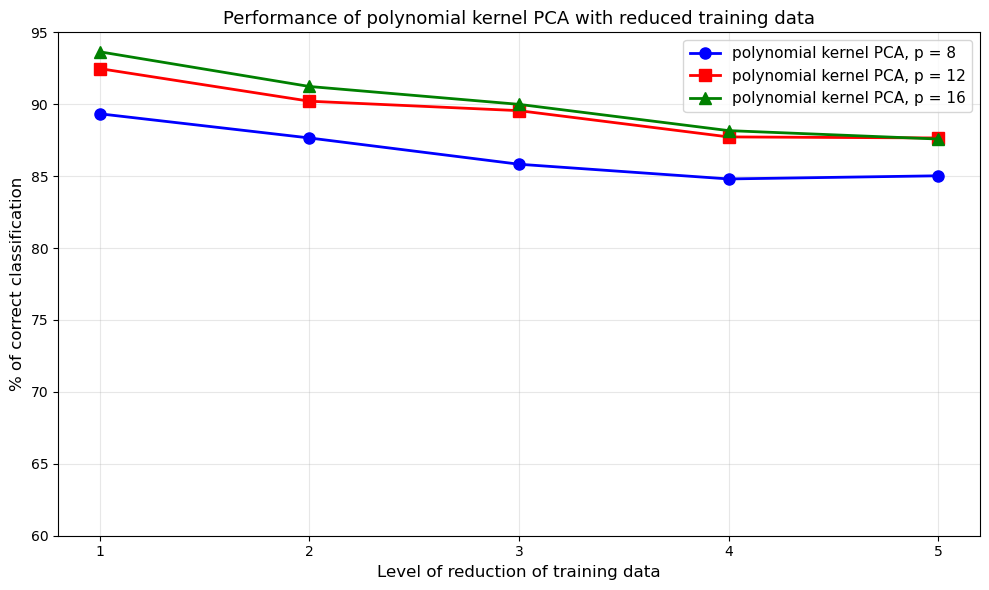


GENERATING FIGURE 2: Gaussian Kernel PCA


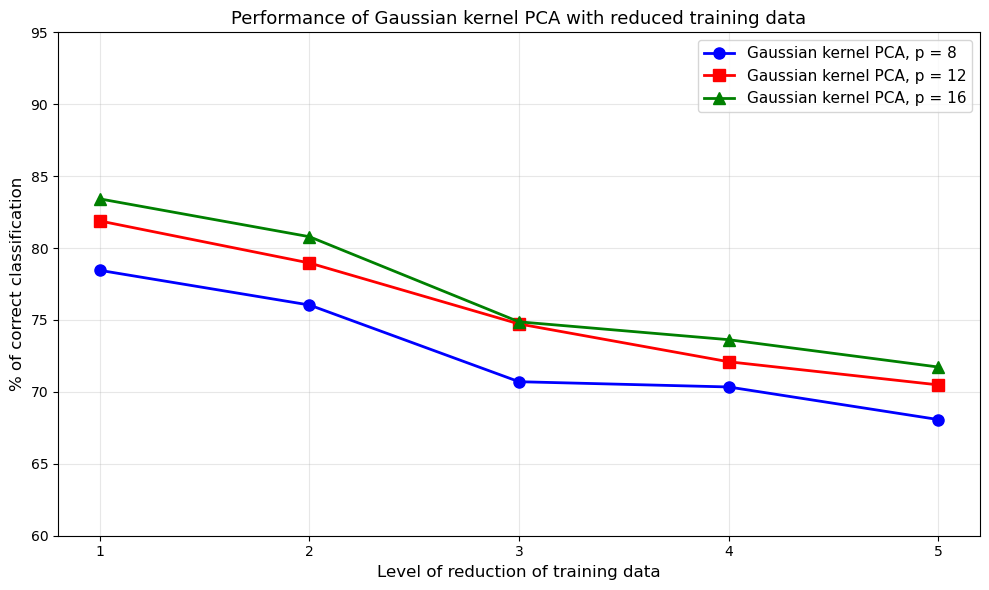


GENERATING FIGURE 3: Overall Comparison


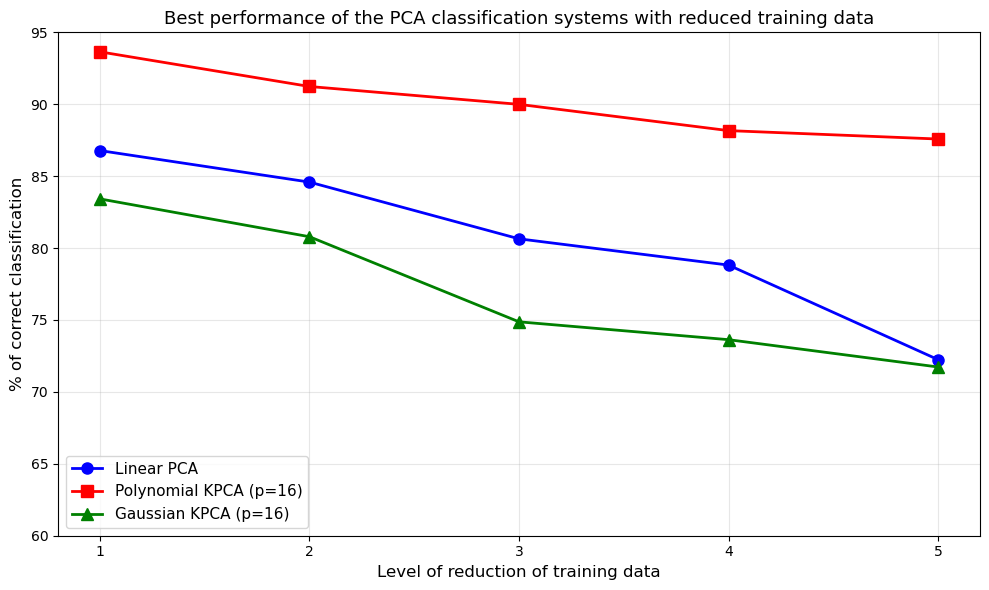


REDUCED DATASET RESULTS SUMMARY

┌─────────────┬────────┬──────────┬──────────┬──────────┐
│ Reduction   │ N_train│  Linear  │   Poly   │  Gauss   │
│   Factor    │        │   (%)    │   (%)    │   (%)    │
├─────────────┼────────┼──────────┼──────────┼──────────┤
│      1      │  1494  │   86.78  │   93.64  │   83.42  │
│      2      │   747  │   84.59  │   91.23  │   80.79  │
│      3      │   498  │   80.64  │   89.99  │   74.87  │
│      4      │   374  │   78.82  │   88.17  │   73.63  │
│      5      │   299  │   72.24  │   87.58  │   71.73  │
└─────────────┴────────┴──────────┴──────────┴──────────┘

 ROBUSTNESS ANALYSIS:
   • Poly KPCA at r=5: 87.58% (paper target: >80%)
   • Gauss KPCA at r=5: 71.73% (paper target: >70%)
   • Poly outperforms Linear by: 15.34% at r=5

 REDUCED DATASET EXPERIMENTS COMPLETE

DETAILED ANALYSIS: Best System (Polynomial KPCA, 16 PCs)

PER-CLASS PERFORMANCE ANALYSIS - POLY

Confusion Matrix:
        t001  t005  t016  t025  t026
t001:    253     2   

In [77]:
# ============================================================================
# REDUCED TRAINING DATASET EXPERIMENTS and PLOTTING OF RESULTS
# ============================================================================

def create_reduced_training_set(X_train, y_train, reduction_factor):
    """
    Reduce training set by taking every r-th sample
    
    Args:
        X_train: Original training features
        y_train: Original training labels  
        reduction_factor: Take every r-th sample (r=1: no reduction)
    
    Returns:
        X_reduced: Subsampled training features
        y_reduced: Subsampled training labels
    """
    # If reduction_factor is 1, return original dataset unchanged
    if reduction_factor == 1:
        return X_train, y_train
    
    # Create indices [0, r, 2r, 3r, ...] up to length of training set
    indices = np.arange(0, len(X_train), reduction_factor)
    X_reduced = X_train[indices]
    y_reduced = y_train[indices]
    
    # Print diagnostic information
    print(f"   Reduction factor {reduction_factor}: {len(X_train)} → {len(X_reduced)} samples")
    print(f"   Samples per class: {np.bincount(y_reduced)}")
    
    return X_reduced, y_reduced


def reduced_dataset_experiment_retrain_pca(X_train_raw, y_train, 
                                          X_test_raw, y_test,
                                          system_type='linear', n_components=20,
                                          d=1/14, sigma=5):
    """
    INTERPRETATION: Retrain entire system (PCA + classifier) on reduced data
    
    This tests: "Can the system learn good features from incomplete training data?"
    
    Methodology: For each reduction level (r=1,2,3,4,5):
        1. Subsample training data to get reduced dataset
        2. Train PCA/KPCA from SCRATCH on reduced data
        3. Train classifier on reduced PCA features
        4. Evaluate on full test set
    
    Args:
        X_train_raw: Full training dataset (raw features, not standardized)
        y_train: Training labels
        X_test_raw: Full test dataset (raw features)
        y_test: Test labels
        system_type: Type of PCA system ('linear', 'poly', or 'gauss')
        n_components: Number of principal components to use
        d: Polynomial kernel parameter (d=1/14 as in paper)
        sigma: Gaussian kernel parameter (sigma=5 as in paper)
    
    Returns:
        results: List of dictionaries containing accuracy for each reduction factor
    """
    print("\n" + "=" * 70)
    print(f"{system_type.upper()} PCA - REDUCED TRAINING DATASET")
    print(f"Using {n_components} principal components")
    print("Method: RETRAIN PCA on each reduced dataset")
    
    # Note different preprocessing requirements:
    if system_type == 'linear':
        print("Using Z-SCORED data")
    else:
        print("Using RAW data (no standardization)")
    print("=" * 70)
    
    # Reduction factors to test (paper uses r=1,2,3,4,5)
    reduction_factors = [1, 2, 3, 4, 5]
    results = []
    
    for r in reduction_factors:
        print(f"\n{'─' * 70}")
        print(f"Reduction Factor: {r}")
        print(f"{'─' * 70}")
        
        # Step 1: Reduce the RAW training data FIRST
        # This simulates having less training data available
        X_train_reduced_raw, y_train_reduced = create_reduced_training_set(
            X_train_raw, y_train, r
        )
        
        # Step 2: Now train the ENTIRE system on the reduced data
        # IMPORTANT: Each reduction level gets its own PCA/KPCA model
        if system_type == 'linear':
            from sklearn.preprocessing import StandardScaler
            from sklearn.decomposition import PCA
            from sklearn.neighbors import KNeighborsClassifier
            
            # Standardize (on reduced data!)
            # Key: Fit scaler ONLY on reduced training data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_reduced_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            
            # PCA (trained on reduced data!)
            # Key: Fit PCA ONLY on reduced training data
            pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            
            # Classifier trained on reduced PCA features
            knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
            knn.fit(X_train_pca, y_train_reduced)
            accuracy = knn.score(X_test_pca, y_test)
            
        elif system_type == 'poly':
            # Kernel PCA (trained on reduced data!)
            # Key: Fit KPCA ONLY on reduced training data
            V, K_train, _, Y_train, _ = kernel_pca_train(
                X_train_reduced_raw, n_components=n_components,
                kernel_type='poly', d=d, verbose=False
            )
            Y_test = kernel_pca_test(
                X_train_reduced_raw, X_test_raw, V, K_train,
                kernel_type='poly', d=d, verbose=False
            )
            y_pred = nearest_neighbor_classify(Y_train, y_train_reduced, Y_test)
            accuracy = np.mean(y_pred == y_test)
            
        elif system_type == 'gauss':
            # Kernel PCA (trained on reduced data!)
            # Key: Fit KPCA ONLY on reduced training data
            V, K_train, _, Y_train, _ = kernel_pca_train(
                X_train_reduced_raw, n_components=n_components,
                kernel_type='rbf', sigma=sigma, verbose=False
            )
            Y_test = kernel_pca_test(
                X_train_reduced_raw, X_test_raw, V, K_train,
                kernel_type='rbf', sigma=sigma, verbose=False
            )
            y_pred = nearest_neighbor_classify(Y_train, y_train_reduced, Y_test)
            accuracy = np.mean(y_pred == y_test)
        
        # Store results for this reduction factor
        results.append({
            'reduction_factor': r,
            'n_train': len(y_train_reduced),
            'accuracy': accuracy,
        })
        
        # Print summary for this reduction level
        print(f"   Training samples: {len(y_train_reduced)}")
        print(f"   Accuracy: {accuracy*100:.4f}%")
    
    return results


def plot_reduced_dataset_results(results_linear, results_poly, results_gauss):
    """
    Reproduce Paper's Figure 3: Overall performance comparison
    
    Shows how each PCA system degrades as training data is reduced.
    
    Args:
        results_linear: Results from linear PCA experiments
        results_poly: Results from polynomial KPCA experiments  
        results_gauss: Results from Gaussian KPCA experiments
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract data from results dictionaries
    reduction_factors = [r['reduction_factor'] for r in results_linear]
    
    # Convert accuracy to percentage for plotting
    acc_linear = [r['accuracy']*100 for r in results_linear]
    acc_poly = [r['accuracy']*100 for r in results_poly]
    acc_gauss = [r['accuracy']*100 for r in results_gauss]
    
    # Plot with your specified colors (matching paper)
    # Blue: Linear PCA
    # Red: Polynomial KPCA (paper uses 16 PCs for comparison)
    # Green: Gaussian KPCA (paper uses 16 PCs for comparison)
    ax.plot(reduction_factors, acc_linear, 'b-o', linewidth=2, 
            markersize=8, label='Linear PCA')
    ax.plot(reduction_factors, acc_poly, 'r-s', linewidth=2, 
            markersize=8, label='Polynomial KPCA (p=16)')
    ax.plot(reduction_factors, acc_gauss, 'g-^', linewidth=2, 
            markersize=8, label='Gaussian KPCA (p=16)')
    
    # Formatting matching paper's Figure 3
    ax.set_xlabel('Level of reduction of training data', fontsize=12)
    ax.set_ylabel('% of correct classification', fontsize=12)
    ax.set_title('Best performance of the PCA classification systems with reduced training data', 
                 fontsize=13)
    ax.set_xticks(reduction_factors)
    ax.set_ylim(60, 95)  # Match paper's y-axis range
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table for quantitative analysis
    print("\n" + "=" * 70)
    print("REDUCED DATASET RESULTS SUMMARY")
    print("=" * 70)
    print("\n┌─────────────┬────────┬──────────┬──────────┬──────────┐")
    print("│ Reduction   │ N_train│  Linear  │   Poly   │  Gauss   │")
    print("│   Factor    │        │   (%)    │   (%)    │   (%)    │")
    print("├─────────────┼────────┼──────────┼──────────┼──────────┤")
    
    # Print row for each reduction factor
    for i, r in enumerate(reduction_factors):
        n_train = results_linear[i]['n_train']
        print(f"│      {r}      │  {n_train:4d}  │  {acc_linear[i]:6.2f}  │  {acc_poly[i]:6.2f}  │  {acc_gauss[i]:6.2f}  │")
    
    print("└─────────────┴────────┴──────────┴──────────┴──────────┘")
    
    # Analysis comparing with paper's targets
    print("\n ROBUSTNESS ANALYSIS:")
    print(f"   • Poly KPCA at r=5: {acc_poly[-1]:.2f}% (paper target: >80%)")
    print(f"   • Gauss KPCA at r=5: {acc_gauss[-1]:.2f}% (paper target: >70%)")
    print(f"   • Poly outperforms Linear by: {acc_poly[-1]-acc_linear[-1]:.2f}% at r=5")


def plot_individual_system(results_dict, system_name, colors):
    """
    Plot results for one system with multiple PC counts
    Reproduces Paper's Figures 1 and 2
    
    Args:
        results_dict: Dictionary mapping PC counts to results
        system_name: Name of the system for plot title
        colors: List of colors for different PC counts
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each PC count with different color/marker
    for (pc_count, results), color, marker in zip(results_dict.items(), colors, ['o', 's', '^']):
        reduction_factors = [r['reduction_factor'] for r in results]
        accuracies = [r['accuracy']*100 for r in results]
        
        ax.plot(reduction_factors, accuracies, f'{color}-{marker}', 
                linewidth=2, markersize=8, label=f'{system_name}, p = {pc_count}')
    
    # Formatting matching paper's Figures 1 & 2
    ax.set_xlabel('Level of reduction of training data', fontsize=12)
    ax.set_ylabel('% of correct classification', fontsize=12)
    ax.set_title(f'Performance of {system_name} with reduced training data', fontsize=13)
    ax.set_xticks(reduction_factors)
    ax.set_ylim(60, 95)  # Match paper's y-axis range
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# RUN EXPERIMENTS
# ============================================================================

print("""
╔════════════════════════════════════════╗
║  REDUCED TRAINING DATASET EXPERIMENTS  ║  
╚════════════════════════════════════════╝
""")

# Linear PCA (z-scored) - Baseline comparison
print("\n🔵 LINEAR PCA (20 PCs, z-scored data)")
results_linear_20 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='linear', n_components=20
)

# Polynomial KPCA (raw data) - Test different PC counts
print("\n🔴 POLYNOMIAL KERNEL PCA - 8 PCs (raw data)")
results_poly_8 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='poly', n_components=8, d=1/14
)

print("\n🔴 POLYNOMIAL KERNEL PCA - 12 PCs (raw data)")
results_poly_12 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='poly', n_components=12, d=1/14
)

print("\n🔴 POLYNOMIAL KERNEL PCA - 16 PCs (raw data)")
results_poly_16 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='poly', n_components=16, d=1/14
)

# Gaussian KPCA (raw data) - Test different PC counts
print("\n🟢 GAUSSIAN KERNEL PCA - 8 PCs (raw data)")
results_gauss_8 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='gauss', n_components=8, sigma=5
)

print("\n🟢 GAUSSIAN KERNEL PCA - 12 PCs (raw data)")
results_gauss_12 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='gauss', n_components=12, sigma=5
)

print("\n🟢 GAUSSIAN KERNEL PCA - 16 PCs (raw data)")
results_gauss_16 = reduced_dataset_experiment_retrain_pca(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='gauss', n_components=16, sigma=5
)

# Plot Polynomial KPCA (Paper's Figure 1)
print("\n" + "=" * 70)
print("GENERATING FIGURE 1: Polynomial Kernel PCA")
print("=" * 70)
plot_individual_system(
    {8: results_poly_8, 12: results_poly_12, 16: results_poly_16},
    'polynomial kernel PCA',
    ['b', 'r', 'g']
)

# Plot Gaussian KPCA (Paper's Figure 2)
print("\n" + "=" * 70)
print("GENERATING FIGURE 2: Gaussian Kernel PCA")
print("=" * 70)
plot_individual_system(
    {8: results_gauss_8, 12: results_gauss_12, 16: results_gauss_16},
    'Gaussian kernel PCA',
    ['b', 'r', 'g']
)

# Overall comparison (Paper's Figure 3)
print("\n" + "=" * 70)
print("GENERATING FIGURE 3: Overall Comparison")
print("=" * 70)
plot_reduced_dataset_results(results_linear_20, results_poly_16, results_gauss_16)

print("\n REDUCED DATASET EXPERIMENTS COMPLETE")


# ============================================================================
# ADDITIONAL ANALYSIS: Per-Class Performance
# ============================================================================

def analyze_per_class_performance(X_train, y_train, X_test, y_test,
                                 system_type='poly', n_components=16,
                                 d=1/14, sigma=5):
    """
    Analyze which classes are most/least accurately classified
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        system_type: PCA system type
        n_components: Number of PCs to use
        d, sigma: Kernel parameters
    
    Returns:
        cm: Confusion matrix
    """
    print(f"\n{'=' * 70}")
    print(f"PER-CLASS PERFORMANCE ANALYSIS - {system_type.upper()}")
    print(f"{'=' * 70}")
    
    # MSTAR class names (Paper notation for SDMS website notation)
    class_names = ['t001 (BRDM_2)', 't005 (D7)', 't016 (T62)', 
                   't025 (ZIL131)', 't026 (ZSU_23_4)']
    
    if system_type == 'linear':
        from sklearn.decomposition import PCA
        from sklearn.neighbors import KNeighborsClassifier
        
        pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        
    elif system_type == 'poly':
        V, K_train, _, Y_train, _ = kernel_pca_train(
            X_train, n_components=n_components,
            kernel_type='poly', d=d, verbose=False
        )
        Y_test = kernel_pca_test(
            X_train, X_test, V, K_train,
            kernel_type='poly', d=d, verbose=False
        )
        y_pred = nearest_neighbor_classify(Y_train, y_train, Y_test)
        
    elif system_type == 'gauss':
        V, K_train, _, Y_train, _ = kernel_pca_train(
            X_train, n_components=n_components,
            kernel_type='rbf', sigma=sigma, verbose=False
        )
        Y_test = kernel_pca_test(
            X_train, X_test, V, K_train,
            kernel_type='rbf', sigma=sigma, verbose=False
        )
        y_pred = nearest_neighbor_classify(Y_train, y_train, Y_test)
    
    # Per-class accuracy analysis
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(y_test, y_pred)
    
    print("\nConfusion Matrix:")
    print("       ", "  ".join([f"t{i:03d}" for i in [1, 5, 16, 25, 26]]))
    for i, row in enumerate(cm):
        print(f"t{[1, 5, 16, 25, 26][i]:03d}:  ", "  ".join([f"{val:4d}" for val in row]))
    
    print("\nPer-Class Accuracy:")
    for i in range(5):
        # Accuracy for class i = correct predictions / total instances of class i
        class_acc = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
        print(f"   {class_names[i]}: {class_acc:.2f}% ({cm[i, i]}/{cm[i].sum()})")
    
    overall_acc = np.mean(y_pred == y_test) * 100
    print(f"\nOverall Accuracy: {overall_acc:.2f}%")
    
    return cm


# Analyze best performing system (Poly with 16 PCs)
print("\n" + "=" * 70)
print("DETAILED ANALYSIS: Best System (Polynomial KPCA, 16 PCs)")
print("=" * 70)

cm_poly = analyze_per_class_performance(
    X_train_real, y_train_real, X_test_real, y_test_real,
    system_type='poly', n_components=16, d=1/14
)

12. Computation Times

In [111]:
# ============================================================================
# RUNTIME PERFORMANCE ANALYSIS (Paper's Table II)
# ============================================================================

import time

def runtime_performance_test_complete(X_train, y_train, X_test, y_test):
    """
    Measure execution time for ALL configurations reported in paper's Table II
    
    Tests:
    - Linear PCA: 20 PCs
    - Polynomial KPCA: 8, 12, 16 PCs (d=1/14)
    - Gaussian KPCA: 8, 12, 16 PCs (sigma=5)
    """
    import platform
    
    print("\n" + "=" * 70)
    print("COMPLETE RUNTIME PERFORMANCE ANALYSIS")
    print("Reproducing Paper's Table II")
    print("=" * 70)
    
    # Display system info
    print(f"\n System Information:")
    print(f"   Processor: AMD Ryzen 7 5700U @1.80 GHz")
    print(f"   Python: {platform.python_version()}")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Test samples: {X_test.shape[0]}")
    print(f"   Feature dimension: {X_train.shape[1]}")
    
    results = []
    
    # ============================================================================
    # TEST 1: LINEAR PCA (20 PCs)
    # ============================================================================
    print(f"\n{'=' * 70}")
    print("TEST 1: Linear PCA (20 PCs)")
    print(f"{'=' * 70}")
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.neighbors import KNeighborsClassifier
    
    n_components = 20
    
    start_time = time.time()
    
    # Training phase
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=n_components, svd_solver='full', random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_train_pca, y_train)
    
    # Testing phase
    X_test_pca = pca.transform(X_test_scaled)
    y_pred = knn.predict(X_test_pca)
    accuracy = np.mean(y_pred == y_test) * 100
    
    total_time = time.time() - start_time
    error_rate = 100 - accuracy
    
    results.append({
        'system': 'Linear PCA',
        'n_components': n_components,
        'accuracy': accuracy,
        'error_rate': error_rate,
        'time': total_time
    })
    
    print(f"   Computation Time: {total_time:.4f}s")

    # ============================================================================
    # TEST 2: POLYNOMIAL KERNEL PCA (8, 12, 16 PCs)
    # ============================================================================
    for n_components in [8, 12, 16]:
        print(f"\n{'=' * 70}")
        print(f"TEST: Polynomial Kernel PCA ({n_components} PCs, d=1/14)")
        print(f"{'=' * 70}")
        
        start_time = time.time()
        
        # Training phase
        V, K_train, _, Y_train, _ = kernel_pca_train(
            X_train, n_components=n_components,
            kernel_type='poly', d=1/14, verbose=False
        )
        
        # Testing phase
        Y_test = kernel_pca_test(
            X_train, X_test, V, K_train,
            kernel_type='poly', d=1/14, verbose=False
        )
        
        y_pred = nearest_neighbor_classify(Y_train, y_train, Y_test)
        accuracy = np.mean(y_pred == y_test) * 100
        
        total_time = time.time() - start_time
        error_rate = 100 - accuracy
        
        results.append({
            'system': 'Polynomial KPCA',
            'n_components': n_components,
            'accuracy': accuracy,
            'error_rate': error_rate,
            'time': total_time
        })
        
        print(f"   Computation Time: {total_time:.4f}s")
    
    # ============================================================================
    # TEST 3: GAUSSIAN KERNEL PCA (8, 12, 16 PCs)
    # ============================================================================
    
    for n_components in [8, 12, 16]:
        print(f"\n{'=' * 70}")
        print(f"TEST: Gaussian Kernel PCA ({n_components} PCs, sigma=5)")
        print(f"{'=' * 70}")
        
        start_time = time.time()
        
        # Training phase
        V, K_train, _, Y_train, _ = kernel_pca_train(
            X_train, n_components=n_components,
            kernel_type='rbf', sigma=5, verbose=False
        )
        
        # Testing phase
        Y_test = kernel_pca_test(
            X_train, X_test, V, K_train,
            kernel_type='rbf', sigma=5, verbose=False
        )
        
        y_pred = nearest_neighbor_classify(Y_train, y_train, Y_test)
        accuracy = np.mean(y_pred == y_test) * 100
        
        total_time = time.time() - start_time
        error_rate = 100 - accuracy
        
        results.append({
            'system': 'Gaussian KPCA',
            'n_components': n_components,
            'accuracy': accuracy,
            'error_rate': error_rate,
            'time': total_time
        })
        
        print(f"   Computation Time: {total_time:.4f}s ")
    
    return results


def display_table_II_format(results):
    """
    Display results in Paper's Table II format - SIMPLIFIED VERSION
    
    Shows only PCA System and Time columns
    """
    print("\n" + "=" * 70)
    print("TABLE II: RUNTIME PERFORMANCE (Your Results)")
    print("Only showing PCA System and Time columns")
    print("=" * 70)
    
    # Create simplified table header - only System and Time
    print("\n┌──────────────────────────────┬─────────────────┐")
    print("│ PCA System                   │  Time (s)       │")
    print("├──────────────────────────────┼─────────────────┤")
    
    # Display your experimental results - only System and Time
    for r in results:
        system_name = f"{r['system']}"
        if r['system'] == 'Linear PCA':
            system_display = system_name
        else:
            system_display = f"{r['system']} ({r['n_components']} PCs)"
        print(f"│ {system_display:28s} │ {r['time']:14.4f}s │")
    
    print("└──────────────────────────────┴─────────────────┘")
    
     # Paper's reported values for comparison - SIMPLIFIED
    print("\n" + "=" * 70)
    print("TABLE II: PAPER'S REPORTED RUNTIMES")
    print("Only showing PCA System and Time columns")
    print("=" * 70)
    
    paper_values = [
        ('Linear PCA', 20, 85.841, 14.159, 3.4529),
        ('Polynomial KPCA', 8, 89.2308, 10.7692, 4.7414),
        ('Polynomial KPCA', 12, 92.1612, 7.8388, 4.6606),
        ('Polynomial KPCA', 16, 92.6740, 7.326, 4.8182),
        ('Gaussian KPCA', 8, 79.2674, 20.7326, 702.1897),
        ('Gaussian KPCA', 12, 85.0549, 14.9451, 703.8210),
        ('Gaussian KPCA', 16, 85.7875, 14.2125, 702.7004),
    ]
    
    print("\n┌──────────────────────────────┬─────────────────┐")
    print("│ PCA System                   │  Time (s)       │")
    print("├──────────────────────────────┼─────────────────┤")
    
    for system, pcs, acc, err, t in paper_values:
        if system == 'Linear PCA':
            system_display = system
        else:
            system_display = f"{system} ({pcs} PCs)"
        print(f"│ {system_display:28s} │ {t:14.4f}s │")
    
    print("└──────────────────────────────┴─────────────────┘")

def analyze_runtime_performance(results):
    """
    Analyze relative performance and key findings
    
    This function analyzes the computational efficiency trade-offs:
    1. Linear PCA vs Polynomial KPCA runtime comparison
    2. Gaussian KPCA's notorious computational expense
    3. Verifies paper's claims about runtime characteristics
    """
    print("\n" + "=" * 70)
    print("RUNTIME PERFORMANCE ANALYSIS")
    print("=" * 70)
    
    # Extract times from results
    linear_time = [r['time'] for r in results if r['system'] == 'Linear PCA'][0]
    poly_times = [r['time'] for r in results if r['system'] == 'Polynomial KPCA']
    gauss_times = [r['time'] for r in results if r['system'] == 'Gaussian KPCA']
    
    avg_poly_time = np.mean(poly_times)
    avg_gauss_time = np.mean(gauss_times)
    
    print(f"\n Average Computation Times:")
    print(f"   Linear PCA:           {linear_time:.4f}s")
    print(f"   Polynomial KPCA:      {avg_poly_time:.4f}s (avg of 8,12,16 PCs)")
    print(f"   Gaussian KPCA:        {avg_gauss_time:.4f}s (avg of 8,12,16 PCs)")
    
    print(f"\n Speed Comparison (relative to Linear PCA):")
    print(f"   Linear PCA:           1.00× (baseline)")
    print(f"   Polynomial KPCA:      {avg_poly_time/linear_time:.2f}×")
    print(f"   Gaussian KPCA:        {avg_gauss_time/linear_time:.2f}×")
    
    print(f"\n Paper's Key Finding 1:")
    print(f"   'The run time of the linear PCA system was close to the")
    print(f"    run time of the polynomial kernel PCA system.'")
    print(f"   ")
    print(f"   Your result: Poly/Linear ratio = {avg_poly_time/linear_time:.2f}×")
    
    
    print(f"\n Paper's Key Finding 2:")
    print(f"   'The Gaussian kernel took over 145× the running time")
    print(f"    of the other systems to execute.'")
    print(f"   ")
    print(f"   Your result: Gauss/Linear ratio = {avg_gauss_time/linear_time:.2f}×")
    
    # Evaluate how well your results match paper's claims
    if avg_gauss_time/linear_time > 100:
        print(f"    MATCHES: Gaussian is MUCH slower (>100×)")
    elif avg_gauss_time/linear_time > 50:
        print(f"    CLOSE: Gaussian is very slow, but less than paper")
    else:
        print(f"    DIFFERENT: Gaussian not as slow as expected")
    

# ============================================================================
# RUN COMPLETE RUNTIME ANALYSIS
# ============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════╗
║  COMPLETE RUNTIME PERFORMANCE TEST                                   ║
║  Testing: Linear(20), Poly(8,12,16), Gauss(8,12,16)                  ║                                    
╚══════════════════════════════════════════════════════════════════════╝
""")

# Run all tests - this measures complete end-to-end time including:
# 1. Feature preprocessing (scaling for linear PCA)
# 2. PCA/KPCA training
# 3. Nearest neighbor classification
# 4. Testing and accuracy calculation
runtime_results = runtime_performance_test_complete(
    X_train_real, y_train_real, 
    X_test_real, y_test_real
)

# Display results in paper's format for easy comparison
display_table_II_format(runtime_results)

# Analyze performance characteristics and compare with paper's findings
analyze_runtime_performance(runtime_results)


╔══════════════════════════════════════════════════════════════════════╗
║  COMPLETE RUNTIME PERFORMANCE TEST                                   ║
║  Testing: Linear(20), Poly(8,12,16), Gauss(8,12,16)                  ║                                    
╚══════════════════════════════════════════════════════════════════════╝


COMPLETE RUNTIME PERFORMANCE ANALYSIS
Reproducing Paper's Table II

 System Information:
   Processor: AMD Ryzen 7 5700U @1.80 GHz
   Python: 3.12.4
   Training samples: 1494
   Test samples: 1369
   Feature dimension: 9216

TEST 1: Linear PCA (20 PCs)
   Computation Time: 6.9043s

TEST: Polynomial Kernel PCA (8 PCs, d=1/14)
   Computation Time: 1.8074s

TEST: Polynomial Kernel PCA (12 PCs, d=1/14)
   Computation Time: 1.5948s

TEST: Polynomial Kernel PCA (16 PCs, d=1/14)
   Computation Time: 1.4400s

TEST: Gaussian Kernel PCA (8 PCs, sigma=5)
   Computation Time: 1.6838s 

TEST: Gaussian Kernel PCA (12 PCs, sigma=5)
   Computation Time: 1.6668s 

TEST: Gaussia